# ECE 670 X1 Mini Project 1

## Task 1 - Mosquito Trap Data and Weather Data

<b>Problem Statement</b>

For Task 1, we were tasked in the creation of 3 regression models using Edmonton weather data and Edmonton Mosquito
Trap data. These models were meant to represent a function between the number of observed mosquitoes when considering a
number of weather features.

In total, 3 models were created:
1. A linear regression model to represent the number of observed mosquitoes given a number of weather features. 
2. A linear regression model to represent the number of female mosquitoes given the same weather data.
3. A polynomial model to model the number of female mosquitoes given the same weather data.

### Data Pre-processing

Prior to creation of a linear regression model, both data sets (Edmonton Mosquito Trap Data and Edmonton Weather Data)
had to be concatenated into a singular data set for analysis. During the initial inspection of the data, the following
was observed:
1. Additional logic had to be added to resolve the 'time grid' utilized by the two sets of data. Where the Mosquito
Trap Data was sampled at a frequency of one data point per week, Edmonton Weather data was sampled once every hour.
2. Because Edmonton weather data is an instantaneous measure at the recorded time, some kind of aggregation of the
weather data is desired to better match the Mosquito Trap data, such as the utilization and calculation of a moving
average for certain features in the weather data set (humidity, temp, dew point, wind_dir_10s, wind_speed, health_index)
3. Within both data sets, some features have inconsistent data and therefore was ignored from the analysis.
Columns with limited or no data, such as visibility, cloud cover, humidex, windchill and solar radiation
were identified as unnecessary to our analysis, and was removed. Similarly, rows with missing data points were
also removed from our analysis.
4. For the Edmonton Mosquito Trap data, rows marked with UnID from the IDd column represented bad data and were
removed from the analysis.

<b>Mosquito Data Pre-processing</b>

For the Mosquito Trap data, we inferred that an average of roughly 20 observations were recorded on a weekly basis of
the number of female and male mosquitoes that were caught in the recovered mosquito traps that were placedk in various
locations in Edmonton. At a glance, it is clear that this data set contains data spanning from 1990 to 2020.

The first desired model takes into account all mosquito genders (male and female) and therefore a method was scripted
in order to facilitate ease in isolating parts of the data set we were interested in if we desired (introduction of an
optional parameter to isolate either only females or only males). Additionally, the helper functions provided
convenience in cleaning the data set in the following ways:
1. The provided trap date column was processed as a datetime object for correct typing
2. Unnecessary columns of the mosquito trap data were removed. These columns included the following: 'Comparison Group',
 'Genus', 'Specific Epithet', 'Trap Region', 'Latitude', 'Longitude', 'Location', 'IDd', 'Include'
3. Removal of all rows marked as No or No Data in the Include column - from the data set description, values of No or
No Data are indicative that the data is of bad quality and therefore should not be considered in our analysis.
4. Summing of the number of mosquitoes on a given date given the mosquito data (all data, female only data, male only data)
5. As our constructed model only requires the number of observed mosquitoes, only the summed number of mosquitoes and
trap date is retained in the final data set.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import helper_functions

# Loading of the mosquito trap data set
mosquito_df = pd.read_csv('data_files/Mosquito_Trap_Data.csv')

# Using helper functions to clean mosquito data frame with previously discussed operations
mosquito_df_all = helper_functions.clean_mosquito_df(mosquito_df, gender=None) # both male and female combined
mosquito_df_all

Following the initial clean up of just the mosquito trap data set, there are 578 rows of data, which is significantly
lower than the original data set which contained 27263 rows of data. Note that this is still sensible as an average of
20 traps were collected on any given trap date, which reduces the intial row value to approximately 1363 rows of data.
Additionally, a total of 829 rows were discarded as these rows were marked as No or No Data in the Include column,
which signifies bad quality data. Hence, our remaining data set for the mosquito data was found to have 578 rows of
data from the initial data set.

<b>Edmonton Weather Data Pre-processing</b>

The feature set utilized in the prediction of the number of mosquitoes found on a given trap date was taken from the
Edmonton Weather data set. At a first glance of the data set, weather related data was recorded on an hourly time
interval for the time period of 2017-2018.

Because the Edmonton weather data consists of instantaneous recordings of Edmonton weather, it was determined that
further data processing would be desirable to better relate the weather to the weekly recorded mosquito trap data. Note
that in this analysis, we assume that the mosquito traps are collected from various locations on a weekly basis, and as
such the number of mosquitoes that are counted are reflective of a weeks worth of mosquitoes landing in the mosquito
trap. Because this observed mosquito count value is not an instantaneous value, it is appropriate to attempt to
match weather data to the same observed period of time (~ 1 week).

When performing data pre-processing for the weather data set, the following operations were conducted:
1. The provided unixtime column was processed as a datetime object for correct typing
2. Moving averages were calculated for different durations of time (1 day, 7 days, 14 days) for specific weather
features ('pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed', 'relative_humidity', 'dew_point',
'temperature')
3. Unnecessary columns of the weather data were removed. These columns included the following: 'unixtime',
'wind_dir', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_8', 'cloud_cover_10',
'solar_radiation'
4. We also create scaled versions of each feature, and the label to compare the performance of the scaled vs unscaled
models.

In [ ]:
# Load the weather data
weather_df = pd.read_csv('data_files/weather_stats_edmonton.csv')

# Clean weather data and perform preprocessing (performing moving average of 7D)
weather_df = helper_functions.clean_weather_df(weather_df)
weather_df = helper_functions.preprocess_weather(weather_df, ['7D'])

<b>Concatenation of the Two Data Sets</b>

Merging of the two data sets was performed with the intent of matching the trap dates given by the mosquito trap data
set. Note that the range of time values given in the weather data set (2017-2018) was not extensive enough to cover the
entire period covered by the mosquito trap data (1990-2020). As a result, following the merge of the two data sets,
only 41 rows were present in the final merged data set.

**Data Set Limitations**

It is of interest to note that the limited number of samples that we were able to obtain following the merge will
likely impact both training and testing of the generated models. Because the limiting data set is the Edmonton weather
data, it is suggested that more weather data should be located so that more mosquito trap dates can be utilized for
better prediction accuracy. As this was beyond the scope of the Mini Project, retrieval of additional weather data was
not conducted; however, it is noted as a limitation for generated model prediction accuracy.

In [ ]:
merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_all, weather_df)

# Removal of columns that reflect instantaenous observations as we will lean towards using moving averages 
# for the creation of the models
instantaneous_weather_recordings = ['pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed',
                                   'wind_gust', 'relative_humidity', 'dew_point', 'temperature']
merged_df.drop(columns=instantaneous_weather_recordings, inplace=True)

# Display the merged data frame
merged_df

### Regression Models

The first model of interest is the creation of a linear regression model that predicts the number of mosquitoes
(in the collected mosquito traps) based on observed Edmonton weather features. For this analysis, the total number of
mosquitoes are used.

<b>1. Number of Mosquitoes vs. Weather Features (Linear Regression)</b>

To facilitate training of the model, we must first divide our limited data samples into a training and testing set.
The training set consists of 70% of the data, while the validation/testing set consists of the remaining 30% of the data.

In [54]:
from sklearn.model_selection import train_test_split

# Define feature set (weather features) and resulting output (number of mosquitoes)
X = merged_df.drop(columns=['Count'])
Y = merged_df['Count']

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn import linear_model

# Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X , Y , test_size = 0.3, random_state = 0)

Standard Scaling:
$$z = \frac{(x - \mu)} {s}$$

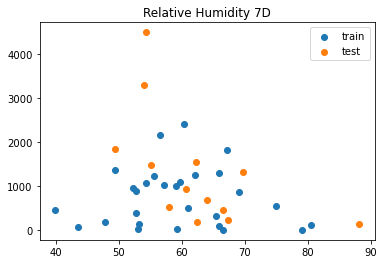

In [55]:
# Plotting one of the features
plt.scatter(X_train['relative_humidity_7D'], Y_train,label='train')
plt.scatter(X_test['relative_humidity_7D'],Y_test, label='test')
plt.title('Relative Humidity 7D')
plt.legend();

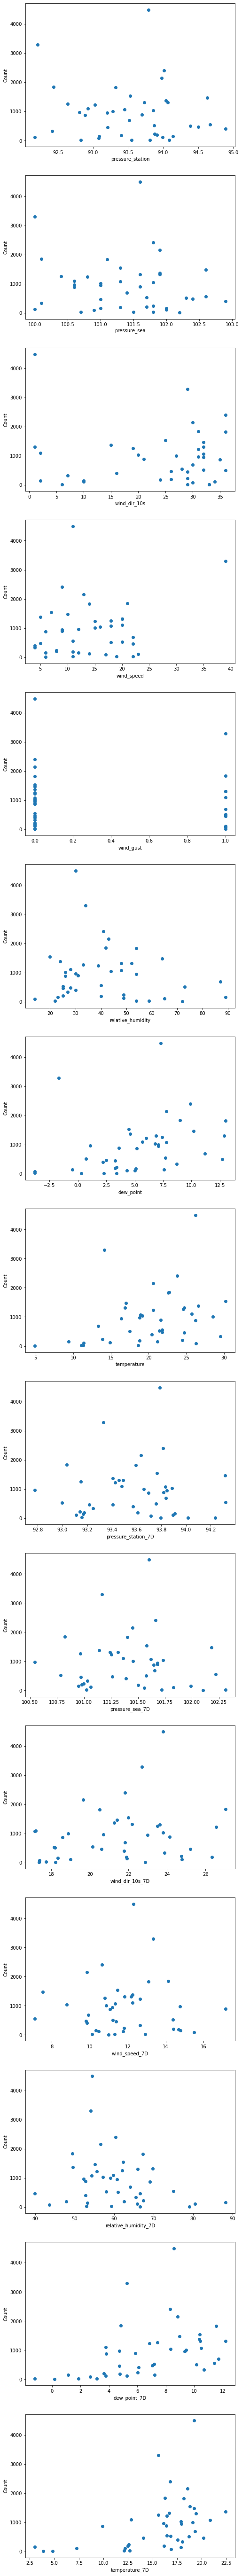

In [67]:
# Plot all features against counts:

fig, axes = plt.subplots(len(X.columns.tolist()), figsize=(8,100))
for i,feature in enumerate(X.columns.tolist()):
    axes[i].scatter(X[feature], Y)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(feature)
plt.show()

Use different cost functions, perform analysis of constructed models, apply normalization and
standardization, feature selection.

### Train 3 different models with no scaling/normalization, scaling, normalization

1. Create models
2. Compare performance
3. Check feature importance in the best model

In [59]:
# 3 Models:
pipe_scaled_reg = Pipeline([('scaler', StandardScaler()), ('linear_regressor_scaled', linear_model.LinearRegression())])
pipe_normalized_reg = Pipeline([('normalizer', Normalizer()), ('linear_regressor_normalized', linear_model.LinearRegression())])
non_scaled_reg = linear_model.LinearRegression() # since all quantities are non-negative

In [76]:
pipe_scaled_reg.fit(X, Y)
pipe_normalized_reg.fit(X, Y)
non_scaled_reg.fit(X, Y)

# We do not need to split the data into test and training set since this is just linear regression with a very small data set (41 observations)
scores = {
    'Raw Regression': [non_scaled_reg.score(X, Y)],
    'Scaled Data': [pipe_scaled_reg.score(X, Y)],
    'Normalized Data': [pipe_normalized_reg.score(X, Y)]
}

pd.DataFrame(scores, index=['R2'])

,Raw Regression,Scaled Data,Normalized Data
R2,0.445106,0.445106,0.531809


In [ ]:
# Add coefficients to see which features are important.